In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.metrics import mean_squared_error, make_scorer
from scipy.stats import skew
from IPython.display import display

from pathlib import Path

# Огругление с точностью до трех знаков после запятой 
pd.set_option('display.float_format', lambda x: '%.3f' % x)
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Импорт данных в dataframe
path = Path('Data')
train = pd.read_csv(path / 'train.csv')
test = pd.read_csv(path / 'test.csv')

In [3]:
# Проверка на дублирование данных и удаление неинформативного признака
idsUnique = len(set(train.Id))
idsTotal = train.shape[0]
idsDupli = idsTotal - idsUnique
print(str(idsDupli) + " дублированных Id из " + str(idsTotal))

print("Размерность обучающей выборки до удаления признака Id: ", train.shape)
print("Размерность тестовой выборки до удаления признака Id: ", test.shape)
train_ID = train['Id']
test_ID = test['Id']
train.drop("Id", axis = 1, inplace = True)
test.drop("Id", axis = 1, inplace = True)
print("\nРазмерность обучающей выборки поле удаления признака Id: ", train.shape) 
print("Размерность тестовой выборки поле удаления признака Id: ", test.shape)

0 дублированных Id из 1460
Размерность обучающей выборки до удаления признака Id:  (1460, 81)
Размерность тестовой выборки до удаления признака Id:  (1459, 80)

Размерность обучающей выборки поле удаления признака Id:  (1460, 80)
Размерность тестовой выборки поле удаления признака Id:  (1459, 79)


### Preprocessing

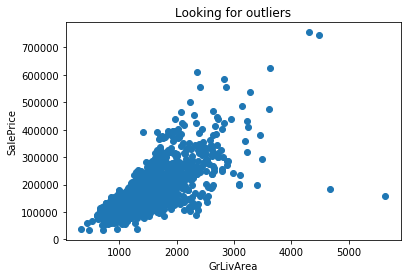

In [4]:
# Проверка на выбросы значений в данных
plt.scatter(train.GrLivArea, train.SalePrice)
plt.title("Looking for outliers")
plt.xlabel("GrLivArea")
plt.ylabel("SalePrice")
plt.show()

train = train[train.GrLivArea < 4000]

В правом нижнем углу есть 2 выброса, где дома с большой площадью продаются по низкой стоимости. 
Автор набора данных рекомендует удалить «любые дома площадью более 4000 квадратных футов» из набора данных. 
Ссылка: https://ww2.amstat.org/publications/jse/v19n3/decock.pdf

In [5]:
# Преобразование целевой метки
# Функция log1p применяет log(1+x) для всех элементов столбца
train.SalePrice = np.log1p(train.SalePrice)
y = train.SalePrice

Text(0.5, 1.0, 'Зависимость процента пропущеных значений от признаков')

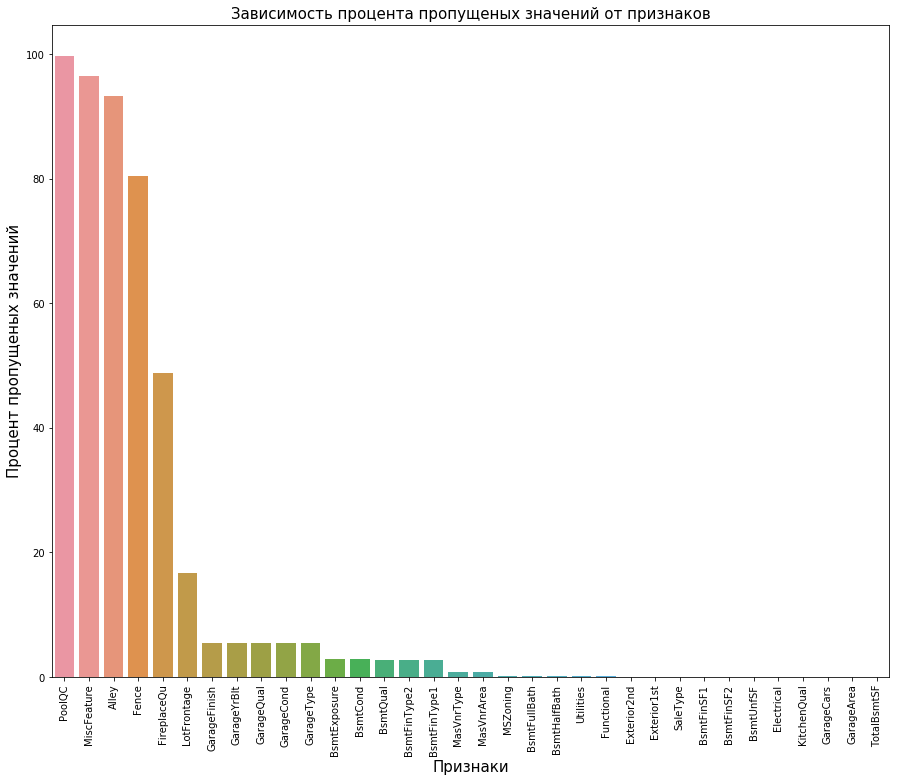

In [6]:
# Пропущеные значения
all_data = pd.concat((train.drop(["SalePrice"], axis=1), test), sort=False)
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)
f, ax = plt.subplots(figsize=(15, 12))

plt.xticks(rotation='90')
sns.barplot(x=all_data_na.index, y=all_data_na)
plt.xlabel('Признаки', fontsize=15)
plt.ylabel('Процент пропущеных значений', fontsize=15)
plt.title('Зависимость процента пропущеных значений от признаков', fontsize=15)

Почти все значения столбца PoolQC равны 0


В строках 960, 1043, 1139 площадь бассейна (PoolArea) принимают некоторые значения, при этом качество бассейна (PoolQC) равно NaN. В данном случае не следует вместо NaN указывать None.

In [7]:
# Обработка пропущенных значений для объектов, где медиана не имеет смысла

all_data = all_data.fillna({"PoolQC": "None"})
all_data = all_data.fillna({"PoolArea": 0})
# MiscFeature : NA - "No misc feature"
all_data = all_data.fillna({"MiscFeature": "None"})
all_data = all_data.fillna({"MiscVal": 0})
# Alley : NA - "No alley access"
all_data = all_data.fillna({"Alley": "None"})
# Fence : NA - "no fence"
all_data = all_data.fillna({"Fence": "None"})
# FireplaceQu : NA - "no fireplace"
all_data = all_data.fillna({"FireplaceQu": "None"})
# LotFrontage : NA - no lot frontage
all_data = all_data.fillna({"LotFrontage": 0})

# GarageType etc : NA - "no garage"
all_data = all_data.fillna({"GarageType": "None"})
all_data = all_data.fillna({"GarageFinish": "None"})
all_data = all_data.fillna({"GarageQual":"None"})
all_data = all_data.fillna({"GarageCond":"None"})
all_data = all_data.fillna({"GarageYrBlt": 0})
all_data = all_data.fillna({"GarageArea": 0})
all_data = all_data.fillna({"GarageCars": 0})


# BsmtQual etc : NA - "no basement"
all_data = all_data.fillna({"BsmtQual": "None"})
all_data = all_data.fillna({"BsmtCond": "None"})
all_data = all_data.fillna({"BsmtExposure": "None"})
all_data = all_data.fillna({"BsmtFinType1": "None"})
all_data = all_data.fillna({"BsmtFinType2": "None"})
all_data = all_data.fillna({"BsmtFinSF1": 0})
all_data = all_data.fillna({"BsmtFinSF2": 0})
all_data = all_data.fillna({"BsmtUnfSF": 0})
all_data = all_data.fillna({"BsmtFullBath": 0})
all_data = all_data.fillna({"BsmtHalfBath": 0})
all_data = all_data.fillna({"TotalBsmtSF": 0})

# MasVnrType : NA - no veneer
all_data = all_data.fillna({"MasVnrType": "None"})
all_data = all_data.fillna({"MasVnrArea": 0})

all_data = all_data.fillna({"MSZoning": "RL"})
all_data = all_data.fillna({"Utilities": "AllPub"})
all_data = all_data.fillna({"Functional": "Typ"})
all_data = all_data.fillna({"Exterior1st": "VinylSd"})
all_data = all_data.fillna({"Exterior2nd": "VinylSd"})

In [8]:
# Преобразование некоторых численных признаков, которые на самом деле категориальные
all_data['MSSubClass'] = all_data['MSSubClass'].apply(str)
all_data['MoSold'] = all_data['MoSold'].apply(str)

In [9]:
from sklearn.preprocessing import LabelEncoder

cotegoror_cols = ("Alley", "BsmtCond", "BsmtExposure", "BsmtFinType1", 
                  "BsmtFinType2", "BsmtQual", "ExterCond", "ExterQual", 
                  "FireplaceQu", "Functional", "GarageCond", "GarageQual", 
                  "HeatingQC", "KitchenQual", "LandSlope", "LotShape", 
                  "PavedDrive", "PoolQC", "Street", "Utilities")
for c in cotegoror_cols:
    lble = LabelEncoder() 
    lble.fit(list(all_data[c].values)) 
    all_data[c] = lble.transform(list(all_data[c].values))
    
print("Размерность данных: ", all_data.shape)

Размерность данных:  (2915, 79)


Создание новых признкаков следующими способами:

1. Упрощение существующих признаков
2. Комбинация существующих признаков
3. Добавление полиномиальных признаков для 10 самых важных

In [10]:
# 1. Упрощение существующих признаков
all_data["SimplOverallQual"] = all_data.OverallQual.replace({1 : 1, 2 : 1, 3 : 1, # bad
                                                       4 : 2, 5 : 2, 6 : 2, # average
                                                       7 : 3, 8 : 3, 9 : 3, 10 : 3 # good
                                                      })
all_data["SimplOverallCond"] = all_data.OverallCond.replace({1 : 1, 2 : 1, 3 : 1, # bad
                                                       4 : 2, 5 : 2, 6 : 2, # average
                                                       7 : 3, 8 : 3, 9 : 3, 10 : 3 # good
                                                      })
all_data["SimplPoolQC"] = all_data.PoolQC.replace({1 : 1, 2 : 1, # average
                                             3 : 2, 4 : 2 # good
                                            })
all_data["SimplGarageCond"] = all_data.GarageCond.replace({1 : 1, # bad
                                                     2 : 1, 3 : 1, # average
                                                     4 : 2, 5 : 2 # good
                                                    })
all_data["SimplGarageQual"] = all_data.GarageQual.replace({1 : 1, # bad
                                                     2 : 1, 3 : 1, # average
                                                     4 : 2, 5 : 2 # good
                                                    })
all_data["SimplFireplaceQu"] = all_data.FireplaceQu.replace({1 : 1, # bad
                                                       2 : 1, 3 : 1, # average
                                                       4 : 2, 5 : 2 # good
                                                      })
all_data["SimplFireplaceQu"] = all_data.FireplaceQu.replace({1 : 1, # bad
                                                       2 : 1, 3 : 1, # average
                                                       4 : 2, 5 : 2 # good
                                                      })
all_data["SimplFunctional"] = all_data.Functional.replace({1 : 1, 2 : 1, # bad
                                                     3 : 2, 4 : 2, # major
                                                     5 : 3, 6 : 3, 7 : 3, # minor
                                                     8 : 4 # typical
                                                    })
all_data["SimplKitchenQual"] = all_data.KitchenQual.replace({1 : 1, # bad
                                                       2 : 1, 3 : 1, # average
                                                       4 : 2, 5 : 2 # good
                                                      })
all_data["SimplHeatingQC"] = all_data.HeatingQC.replace({1 : 1, # bad
                                                   2 : 1, 3 : 1, # average
                                                   4 : 2, 5 : 2 # good
                                                  })
all_data["SimplBsmtFinType1"] = all_data.BsmtFinType1.replace({1 : 1, # unfinished
                                                         2 : 1, 3 : 1, # rec room
                                                         4 : 2, 5 : 2, 6 : 2 # living quarters
                                                        })
all_data["SimplBsmtFinType2"] = all_data.BsmtFinType2.replace({1 : 1, # unfinished
                                                         2 : 1, 3 : 1, # rec room
                                                         4 : 2, 5 : 2, 6 : 2 # living quarters
                                                        })
all_data["SimplBsmtCond"] = all_data.BsmtCond.replace({1 : 1, # bad
                                                 2 : 1, 3 : 1, # average
                                                 4 : 2, 5 : 2 # good
                                                })
all_data["SimplBsmtQual"] = all_data.BsmtQual.replace({1 : 1, # bad
                                                 2 : 1, 3 : 1, # average
                                                 4 : 2, 5 : 2 # good
                                                })
all_data["SimplExterCond"] = all_data.ExterCond.replace({1 : 1, # bad
                                                   2 : 1, 3 : 1, # average
                                                   4 : 2, 5 : 2 # good
                                                  })
all_data["SimplExterQual"] = all_data.ExterQual.replace({1 : 1, # bad
                                                   2 : 1, 3 : 1, # average
                                                   4 : 2, 5 : 2 # good
                                                  })

In [11]:
# 2. Комбинация существующих признаков
# Общее состояние дома
all_data["OverallGrade"] = all_data["OverallQual"] * all_data["OverallCond"]
# Общее состояние гаража
all_data["GarageGrade"] = all_data["GarageQual"] * all_data["GarageCond"]
# Общее состояние облицовки
all_data["ExterGrade"] = all_data["ExterQual"] * all_data["ExterCond"]
# Общее характеристики кухни
all_data["KitchenScore"] = all_data["KitchenAbvGr"] * all_data["KitchenQual"]
# Общее характеристики камина
all_data["FireplaceScore"] = all_data["Fireplaces"] * all_data["FireplaceQu"]
# Общее характеристики гаража
all_data["GarageScore"] = all_data["GarageArea"] * all_data["GarageQual"]
# Общее характеристики бассейна
all_data["PoolScore"] = all_data["PoolArea"] * all_data["PoolQC"]
# Упрощенное общее сосотояние дома
all_data["SimplOverallGrade"] = all_data["SimplOverallQual"] * all_data["SimplOverallCond"]
# Упрощенное общее сосотояние облицовки 
all_data["SimplExterGrade"] = all_data["SimplExterQual"] * all_data["SimplExterCond"]
# Упрощенные общие характеристики бассейна
all_data["SimplPoolScore"] = all_data["PoolArea"] * all_data["SimplPoolQC"]
# Упрощенные общие характеристики гаража
all_data["SimplGarageScore"] = all_data["GarageArea"] * all_data["SimplGarageQual"]
# Упрощенные общие характеристики камина
all_data["SimplFireplaceScore"] = all_data["Fireplaces"] * all_data["SimplFireplaceQu"]
# Упрощенные общие характеристики кухни
all_data["SimplKitchenScore"] = all_data["KitchenAbvGr"] * all_data["SimplKitchenQual"]
# Общее колисетво уборных
all_data["TotalBath"] = all_data["BsmtFullBath"] + (0.5 * all_data["BsmtHalfBath"]) + \
all_data["FullBath"] + (0.5 * all_data["HalfBath"])
# Общая прощадь подвала и "above grade" 
all_data["AllSF"] = all_data["GrLivArea"] + all_data["TotalBsmtSF"]
# Общая прощадь первого и второго этажей
all_data["AllFlrsSF"] = all_data["1stFlrSF"] + all_data["2ndFlrSF"]
# Общая прощадь терассы
all_data["AllPorchSF"] = all_data["OpenPorchSF"] + all_data["EnclosedPorch"] + \
all_data["3SsnPorch"] + all_data["ScreenPorch"]
# Облицовка шпоном или нет
all_data["HasMasVnr"] = all_data.MasVnrType.replace({"BrkCmn" : 1, "BrkFace" : 1, "CBlock" : 1, 
                                               "Stone" : 1, "None" : 0})
# Дом завершен перед продажей или нет 
all_data["BoughtOffPlan"] = all_data.SaleCondition.replace({"Abnorml" : 0, "Alloca" : 0, "AdjLand" : 0, 
                                                      "Family" : 0, "Normal" : 0, "Partial" : 1})

In [12]:
# Поиск наиболее важных признаков относительно целевой метки
corr = train.corr()
corr.sort_values(["SalePrice"], ascending = False, inplace = True)
print(corr.SalePrice)

SalePrice        1.000
OverallQual      0.819
GrLivArea        0.719
GarageCars       0.680
GarageArea       0.655
TotalBsmtSF      0.642
1stFlrSF         0.614
FullBath         0.591
YearBuilt        0.589
YearRemodAdd     0.569
GarageYrBlt      0.544
TotRmsAbvGrd     0.533
Fireplaces       0.487
MasVnrArea       0.430
BsmtFinSF1       0.383
LotFrontage      0.363
WoodDeckSF       0.331
OpenPorchSF      0.327
HalfBath         0.311
2ndFlrSF         0.307
LotArea          0.259
BsmtFullBath     0.239
BsmtUnfSF        0.223
BedroomAbvGr     0.204
ScreenPorch      0.124
MoSold           0.062
3SsnPorch        0.056
PoolArea         0.041
BsmtFinSF2       0.006
BsmtHalfBath    -0.015
MiscVal         -0.020
YrSold          -0.034
OverallCond     -0.037
LowQualFinSF    -0.038
MSSubClass      -0.075
KitchenAbvGr    -0.148
EnclosedPorch   -0.149
Name: SalePrice, dtype: float64


In [13]:
# 3. Добавление полиномиальных признаков для 10 самых важных
cols = corr.SalePrice.index[1:11].tolist()
for col in cols:
    all_data[col+'-2'] = all_data.loc[:,col]**2
    all_data[col+'-3'] = all_data.loc[:,col]**3
    all_data[col+'-Sq'] = np.sqrt(np.absolute(all_data.loc[:,col]))

In [14]:
# Разделение данных на категориальные и численные признаки
categorical_features = all_data.select_dtypes(include = ["object"]).columns
numerical_features = all_data.select_dtypes(exclude = ["object"]).columns

print("Численные признаки : " + str(len(numerical_features)))
print("Категориальные признаки : " + str(len(categorical_features)))

all_data_num = all_data[numerical_features]
all_data_cat = all_data[categorical_features]

Численные признаки : 118
Категориальные признаки : 25


In [15]:
# Заполнение остальных пропущенных значений для численных признаков медианой
print("Количество пропущеных значений (численные признаки): " + str(all_data_num.isnull().values.sum()))
all_data_num = all_data_num.fillna(all_data_num.median())
print("Оставшееся количество пропущеных значений: " + str(all_data_num.isnull().values.sum()))

Количество пропущеных значений (численные признаки): 0
Оставшееся количество пропущеных значений: 0


In [16]:
# Логарифмическое преобразование численных признаков для уменьшения влияния выбросов
# skewness < 0.5 (можно попробовать 0.75) допустимая ассиметрия
skewness = all_data_num.apply(lambda x: skew(x)) 
skewness = skewness[abs(skewness) > 0.5]

skewed_features = skewness.index
all_data_num[skewed_features] = np.log1p(all_data_num[skewed_features])
print(str(skewness.shape[0]) + " признаков было преобразовано")

90 признаков было преобразовано


In [17]:
# Преобразование категориальных признаков в численные
print("Количество пропущеных значений (категориальные признаки): " + str(all_data_cat.isnull().values.sum()))
all_data_cat = pd.get_dummies(all_data_cat)
print("Оставшееся количество пропущеных значений: " + str(all_data_cat.isnull().values.sum()))

Количество пропущеных значений (категориальные признаки): 2
Оставшееся количество пропущеных значений: 0


In [18]:
# Объединение признаков
all_data_num_cat = pd.concat([all_data_num, all_data_cat], axis = 1)
print("Количество категориальных признаков после преобразований: " + str(train.shape[1]))

# Разделение обработанных данных 50/50 как было изначально
train = all_data_num_cat[:train.shape[0]]
test = all_data_num_cat[train.shape[0]:]

Количество категориальных признаков после преобразований: 80


### Modeling

In [19]:
# Определение функции расчета RMSE
scorer = make_scorer(mean_squared_error, greater_is_better = False)

def rmse_cv_train(model):
    rmse= np.sqrt(-cross_val_score(model, train, y, scoring = scorer, cv = 10))
    return(rmse)

**1.  Линейная регрессия без регуляризации**

RMSE для обучающей выборки: 1.7256697764502622


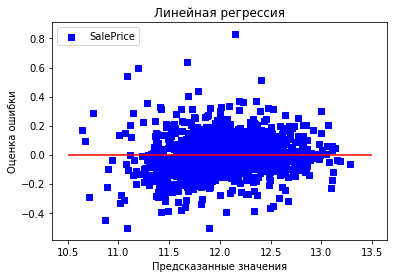

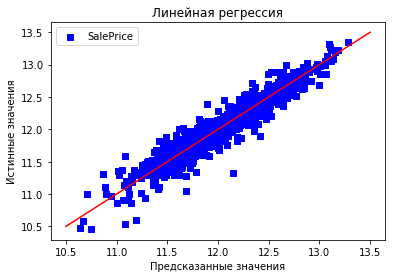

In [20]:
lr = LinearRegression()
lr.fit(train, y)

# Предсказанные значения для обучающей и тестовой выборок
print("RMSE для обучающей выборки:", rmse_cv_train(lr).mean())
y_train_pred = lr.predict(train)

# Оценка ошибки
plt.scatter(y_train_pred, y_train_pred - y, c = "blue", marker = "s")
plt.title("Линейная регрессия")
plt.xlabel("Предсказанные значения")
plt.ylabel("Оценка ошибки")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = 10.5, xmax = 13.5, color = "red")
plt.show()

# Предсказанные значения - истинные значения
plt.scatter(y_train_pred, y, c = "blue", marker = "s")
plt.title("Линейная регрессия")
plt.xlabel("Предсказанные значения")
plt.ylabel("Истинные значения")
plt.legend(loc = "upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], c = "red")
plt.show()

Оценки ошибок случайно распределенны относительно целевой метки. Это означает, что модель смогла собрать большую часть пояснительной информации.

**2. Линейная регрессия c L2-регуляризацией (Ridge Regression)**

Из книги Себастьяна Рашка "Python и машинное обучение":

"Регуляризация - очень полезный метод для обработки коллинеарности (высокой корреляции среди признаков), фильтрации шума из данных и в конечном счете предотвращения переобучения. В основе регуляризации лежит идея внесения дополнительной информации (смещения) для наложения штрафа на экстремальные веса параметров. Самой стандартной формой регуляризации является так называемая L2-регуляризация."

Лучшее значение alpha: 10.0
Более точное значение alpha : 8.0
Ridge RMSE на обучающей выборке: 0.11116128929404154


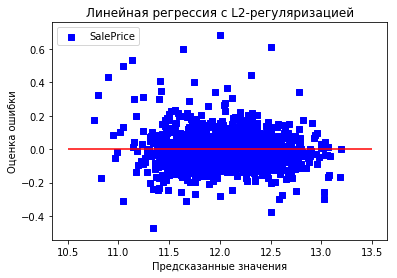

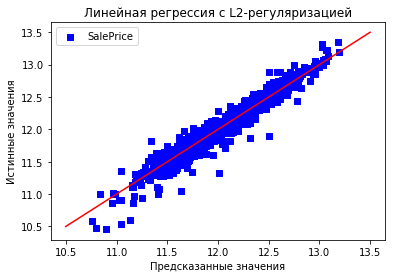

317 признаков, где весовые коэффициенты не равны 0
1 исключен(ы)


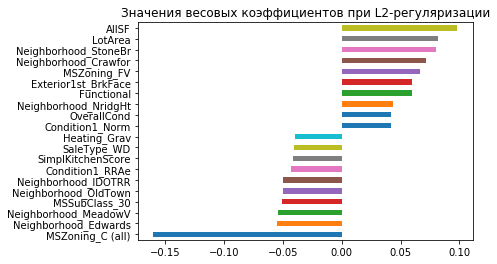

In [21]:
ridge = RidgeCV(alphas = [0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1, 3, 6, 10, 30, 60])
ridge.fit(train, y)
alpha = ridge.alpha_
print("Лучшее значение alpha:", alpha)

# Повышение точности значения alpha
ridge_alpha = RidgeCV(alphas = [alpha * .6, alpha * .65, alpha * .7, alpha * .75, alpha * .8, alpha * .85, 
                          alpha * .9, alpha * .95, alpha, alpha * 1.05, alpha * 1.1, alpha * 1.15,
                          alpha * 1.25, alpha * 1.3, alpha * 1.35, alpha * 1.4], 
                cv = 10)
ridge_alpha.fit(train, y)
alpha = ridge_alpha.alpha_
print("Более точное значение alpha :", alpha)
print("Ridge RMSE на обучающей выборке:", rmse_cv_train(ridge_alpha).mean())
y_train_rdg = ridge_alpha.predict(train)

# Оценка ошибки
plt.scatter(y_train_rdg, y_train_rdg - y, c = "blue", marker = "s")
plt.title("Линейная регрессия c L2-регуляризацией")
plt.xlabel("Предсказанные значения")
plt.ylabel("Оценка ошибки")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = 10.5, xmax = 13.5, color = "red")
plt.show()

# Предсказанные значения - истинные значения
plt.scatter(y_train_rdg, y, c = "blue", marker = "s")
plt.title("Линейная регрессия c L2-регуляризацией")
plt.xlabel("Предсказанные значения")
plt.ylabel("Истинные значения")
plt.legend(loc = "upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], c = "red")
plt.show()

# Весовые коэффициенты признаков
coefs = pd.Series(ridge_alpha.coef_, index = train.columns)
print(str(sum(coefs != 0)) + " признаков, где весовые коэффициенты не равны 0\n" + \
      str(sum(coefs == 0)) + " исключен(ы)")
imp_coefs = pd.concat([coefs.sort_values().head(10),
                     coefs.sort_values().tail(10)])
imp_coefs.plot(kind = "barh")
plt.title("Значения весовых коэффициентов при L2-регуляризации")
plt.show()

**3. Линейная регрессия c L1-регуляризацией (Lasso Regression)**

L1-регуляризации служит в качестве метода отбора признаков и большинство весов признаков будет равно 0. В результате получается модель устойчивая к потенциально нерелевантным (лишним) признакам в этом наборе данных.

Лучшее значение alpha: 0.0003
Более точное значение alpha: 0.00034499999999999993
Lasso RMSE на обучающей выборке: 0.10743777373732674


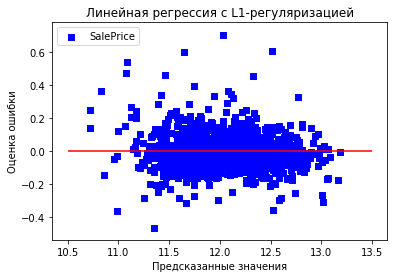

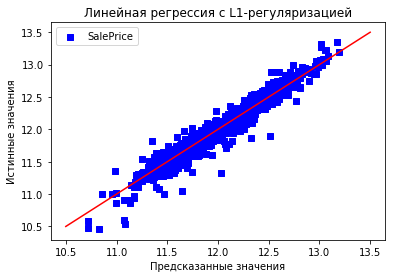

121признаков, где весовые коэффициенты не равны 0.
197 признаков было исключено


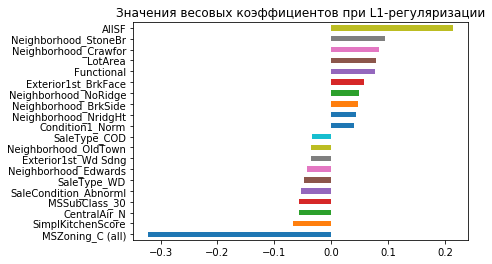

In [22]:
lasso = LassoCV(alphas = [0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 0.01, 0.03, 0.06, 0.1, 
                          0.3, 0.6, 1], 
                max_iter = 1000, cv = 10)
lasso.fit(train, y)
alpha = lasso.alpha_
print("Лучшее значение alpha:", alpha)

# Повышение точности значения alpha
lasso = LassoCV(alphas = [alpha * .6, alpha * .65, alpha * .7, alpha * .75, alpha * .8, 
                          alpha * .85, alpha * .9, alpha * .95, alpha, alpha * 1.05, 
                          alpha * 1.1, alpha * 1.15, alpha * 1.25, alpha * 1.3, alpha * 1.35, 
                          alpha * 1.4], 
                max_iter = 1000, cv = 10)
lasso.fit(train, y)
alpha = lasso.alpha_
print("Более точное значение alpha:", alpha)

print("Lasso RMSE на обучающей выборке:", rmse_cv_train(lasso).mean())
y_train_las = lasso.predict(train)

# Оценка ошибки
plt.scatter(y_train_las, y_train_las - y, c = "blue", marker = "s")
plt.title("Линейная регрессия c L1-регуляризацией")
plt.xlabel("Предсказанные значения")
plt.ylabel("Оценка ошибки")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = 10.5, xmax = 13.5, color = "red")
plt.show()

# Предсказанные значения - истинные значения
plt.scatter(y_train_las, y, c = "blue", marker = "s")
plt.title("Линейная регрессия c L1-регуляризацией")
plt.xlabel("Предсказанные значения")
plt.ylabel("Истинные значения")
plt.legend(loc = "upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], c = "red")
plt.show()

# Весовые коэффициенты признаков
coefs = pd.Series(lasso.coef_, index = train.columns)
print(str(sum(coefs != 0)) + "признаков, где весовые коэффициенты не равны 0.\n" + \
      str(sum(coefs == 0)) + " признаков было исключено")
imp_coefs = pd.concat([coefs.sort_values().head(10),
                     coefs.sort_values().tail(10)])
imp_coefs.plot(kind = "barh")
plt.title("Значения весовых коэффициентов при L1-регуляризации")
plt.show()

RMSE улучшилось, при этом модель c L1-регуляризацией задействовала только одну треть доступных функций. Высокое значение весового коэффициента признака Neighborhood_Crawfor можно интерпритировать так, что в зависимости от района в пределах одного города, цена на недвижимость сильно меняется.

Признак MSZoning_C (all), имеет подозрительно высокое значение весового коэффициента, поскольку зона комерческой деятельности не так плоха как, напимер, промышленная зона. Возможно это из-за несбаланисированности выборки.

**4.  Линейная регрессия c ElasticNet-регуляризацией**

Метод эластичной сети - это метод регуляризованной регрессии, компенсирующий недостатки
метода lasso (число отобранных переменных) добавлением L1- и L2-штрафов.

Лучшее значение l1_ratio: 1.0
Лучшее значение alpha: 0.0003
Более точное значение l1_ratio: 1
Более точное значение alpha: 0.0003
Конечное значение l1_ratio : 1
Конечное значение alpha : 0.00034499999999999993
ElasticNet RMSE на обучающей выборке: 0.10743777373732674


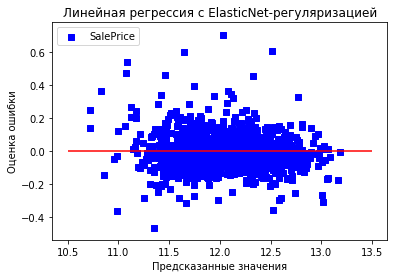

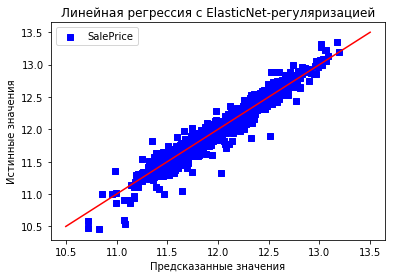

121признаков, где весовые коэффициенты не равны 0.
197 признаков было исключено


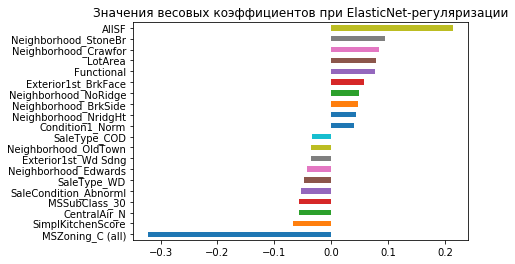

In [23]:
elasticNet = ElasticNetCV(l1_ratio = [0.1, 0.3, 0.5, 0.6, 0.7, 0.8, 0.85, 0.9, 0.95, 1],
                          alphas = [0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 
                                    0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1, 3, 6], 
                          max_iter = 1000, cv = 10)
elasticNet.fit(train, y)
alpha = elasticNet.alpha_
ratio = elasticNet.l1_ratio_
print("Лучшее значение l1_ratio:", ratio)
print("Лучшее значение alpha:", alpha )

# Повышение точности значения l1_ratio
elasticNet = ElasticNetCV(l1_ratio = [ratio * .85, ratio * .9, ratio * .95, ratio, ratio * 1.05, ratio * 1.1, ratio * 1.15],
                          alphas = [0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1, 3, 6], 
                          max_iter = 1000, cv = 10)
elasticNet.fit(train, y)
if (elasticNet.l1_ratio_ > 1):
    elasticNet.l1_ratio_ = 1    
alpha = elasticNet.alpha_
ratio = elasticNet.l1_ratio_
print("Более точное значение l1_ratio:", ratio)
print("Более точное значение alpha:", alpha )

# Повышение точности значения alpha при фиксированном значении l1_ratio
elasticNet = ElasticNetCV(l1_ratio = ratio,
                          alphas = [alpha * .6, alpha * .65, alpha * .7, alpha * .75, alpha * .8, alpha * .85, alpha * .9, 
                                    alpha * .95, alpha, alpha * 1.05, alpha * 1.1, alpha * 1.15, alpha * 1.25, alpha * 1.3, 
                                    alpha * 1.35, alpha * 1.4], 
                          max_iter = 1000, cv = 10)
elasticNet.fit(train, y)
if (elasticNet.l1_ratio_ > 1):
    elasticNet.l1_ratio_ = 1    
alpha = elasticNet.alpha_
ratio = elasticNet.l1_ratio_
print("Конечное значение l1_ratio :", ratio)
print("Конечное значение alpha :", alpha )

print("ElasticNet RMSE на обучающей выборке:", rmse_cv_train(elasticNet).mean())
y_train_ela = elasticNet.predict(train)

# Оценка ошибки
plt.scatter(y_train_ela, y_train_ela - y, c = "blue", marker = "s")
plt.title("Линейная регрессия c ElasticNet-регуляризацией")
plt.xlabel("Предсказанные значения")
plt.ylabel("Оценка ошибки")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = 10.5, xmax = 13.5, color = "red")
plt.show()

# Предсказанные значения - истинные значения
plt.scatter(y_train_ela, y,  c = "blue", marker = "s")
plt.title("Линейная регрессия c ElasticNet-регуляризацией")
plt.xlabel("Предсказанные значения")
plt.ylabel("Истинные значения")
plt.legend(loc = "upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], c = "red")
plt.show()

# Весовые коэффициенты признаков
coefs = pd.Series(elasticNet.coef_, index = train.columns)
print(str(sum(coefs != 0)) + "признаков, где весовые коэффициенты не равны 0.\n" + \
      str(sum(coefs == 0)) + " признаков было исключено")
imp_coefs = pd.concat([coefs.sort_values().head(10),
                     coefs.sort_values().tail(10)])
imp_coefs.plot(kind = "barh")
plt.title("Значения весовых коэффициентов при ElasticNet-регуляризации")
plt.show()

В линейной регрессии c ElasticNet-регуляризацией параметр l1_ratio равен 1 (Lasso Regression), который продемонстрирован ранее. Это объясняет то, что RMSE в этих моделях одинаковый.

**5.  Градиентный бустинг**

Идея градиентного бустинга заключается в итеративном процессе последовательного построения частных моделей. Каждая новая модель обучается с использованием информации об ошибках, сделанных на предыдущем этапе, а результирующая функция представляет собой линейную комбинацию всего ансамбля моделей с учетом минимизации любой штрафной функции. 

In [24]:
import xgboost as xgb
from xgboost import XGBRegressor

dtrain = xgb.DMatrix(train, label = y)
dtest = xgb.DMatrix(test)

params = {"max_depth":2, "eta":0.1}
model = xgb.cv(params, dtrain,  num_boost_round=500, early_stopping_rounds=100)

[00:42:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[00:42:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[00:42:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[00:42:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[00:42:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[00:42:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[00:42:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[00:42:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[00:42:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[

Text(0, 0.5, 'rmse')

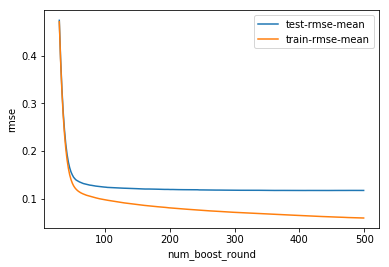

In [25]:
model.loc[30:,["test-rmse-mean", "train-rmse-mean"]].plot()
plt.xlabel("num_boost_round")
plt.ylabel("rmse")

In [26]:
model_xgb = xgb.XGBRegressor(n_estimators=350, max_depth=2, learning_rate=0.1)
model_xgb.fit(train, y)
print("XGBRegressor RMSE на обучающей выборке:", rmse_cv_train(model_xgb).mean())

XGBRegressor RMSE на обучающей выборке: 0.11415654923684518


**Submission File**

In [27]:
predicted_prices = lasso.predict(test)
predicted_prices = np.expm1(predicted_prices)
my_submission = pd.DataFrame({'Id': test_ID, 'SalePrice': predicted_prices})
my_submission.to_csv('submission.csv', index=False)